In [14]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.decomposition import PCA
from scipy.stats import zscore
import os
from sklearn.mixture import GaussianMixture
from nilearn import plotting, image
import numpy as np
from scipy.signal import butter, filtfilt

from Tools.fmri_tools import *

In [15]:
def estimate_best_lag(pupil, fmri, max_lag=20):
    """
    Stima il lag (in campioni) che massimizza la correlazione lineare
    tra 'pupil' e 'fmri'.
    
    Parameters
    ----------
    pupil : np.ndarray
        Serie temporale del diametro pupillare, shape (T,).
    fmri : np.ndarray
        Serie temporale fMRI (ad es. media ROI o primo PC), shape (T,).
    max_lag : int
        Il lag massimo (in campioni) da esplorare in avanti o indietro. 
    
    Returns
    -------
    best_lag : int
        Il lag (positivo o negativo) che massimizza la correlazione.
        Se best_lag > 0, vuol dire che la fMRI è in ritardo (lag) 
        rispetto al segnale pupillare.
    best_corr : float
        Valore di correlazione (Pearson) massimo riscontrato.
    all_corr : dict
        Dizionario con lag -> correlazione, utile per debug o plotting.
    """
    # Assicuriamoci che i due segnali abbiano la stessa lunghezza
    T = min(len(pupil), len(fmri))
    pupil = pupil[:T]
    fmri = fmri[:T]
    
    # Normalizziamo (z-score) i dati per evitare offset
    p_mean, p_std = pupil.mean(), pupil.std()
    pupil_z = (pupil - p_mean) / (p_std if p_std>0 else 1e-8)
    
    f_mean, f_std = fmri.mean(), fmri.std()
    fmri_z = (fmri - f_mean) / (f_std if f_std>0 else 1e-8)

    # Converti fmri_z in un array 1D se è 2D
    fmri_z = np.squeeze(fmri_z)
    
    # Per memorizzare i risultati
    lags = range(-max_lag, max_lag + 1)
    all_corr = {}
    
    best_corr = 999
    best_lag = 0
    
    for lag in lags:
        if lag < 0:
            # Se lag è negativo, shiftiamo in avanti pupil
            # Esempio: pupil(t + lag) ~ pupil spostato in avanti
            # Quindi fmri(t) corrisponde a pupil(t + lag)
            # => pupil_z[:lag] vs fmri_z[-lag:]
            shifted_p = pupil_z[:lag]   # da 0 a T+lag
            shifted_f = fmri_z[-lag:]  # da -lag a T
        else:
            # lag >= 0
            # fmri(t) corrisponde a pupil(t - lag)
            # => pupil_z[lag:] vs fmri_z[:T-lag]
            shifted_p = pupil_z[lag:]   
            shifted_f = fmri_z[:len(pupil_z[lag:])]  # che è T-lag
        
        # Calcola correlazione di Pearson
        if len(shifted_p) > 1 and len(shifted_p) == len(shifted_f):
            corr = np.corrcoef(shifted_p, shifted_f)[0, 1]
        else:
            corr = np.nan
        
        all_corr[lag] = corr
        if corr < best_corr:
            best_corr = corr
            best_lag = lag
    
    return best_lag, best_corr, all_corr

In [16]:
#Loading the functional data from file

fmri_name = 'rs-fmri-2.npz'
frmi_path = os.path.join('..',"Compressed Smoothed Data",fmri_name) 
index = extract_number_from_filename(fmri_name)
data = np.load(frmi_path)
functional_data_res = data['functional_data_res']
print('Functional data shape:',functional_data_res.shape)

#Loading pupil data:
file_name = os.path.join('..','pupil_diameter_74_trials.npy')

pupil = np.load(file_name)
pupil = pupil[(index-1),:]
fmin = 0.01
fmax = 0.05
b, a = butter(4, [fmin,fmax], 'bandpass')
pupil_filtered = filtfilt(b, a, pupil,padlen=10) 
print('Pupil data shape:',pupil_filtered.shape)

Functional data shape: (21680, 925)
Pupil data shape: (925,)


In [17]:
print('Functional data res shape:',np.shape(functional_data_res))
pca = PCA(n_components=1)
y=pca.fit_transform(functional_data_res.T)
print(np.shape(y))
b, a = butter(4, [fmin,fmax], 'bandpass')
y_filtered = filtfilt(b, a, y,padlen=10,axis=0)

Functional data res shape: (21680, 925)


(925, 1)


In [18]:
lag, corr, corr_dict = estimate_best_lag(pupil_filtered, y_filtered, max_lag=20)
print(f"Miglior lag: {lag} campioni con correlazione={corr:.3f}")

Miglior lag: 13 campioni con correlazione=-0.646


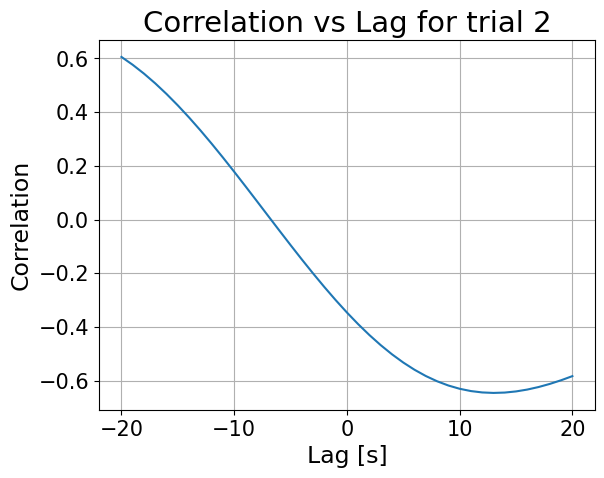

Max Negative correlation: -0.645538052222378 for lag: 13


In [19]:
fmri_name = fmri_name.replace('.npz', '')
index = extract_number_from_filename(fmri_name)
plt.plot(list(corr_dict.keys()), list(corr_dict.values()))
plt.xlabel('Lag [s]', fontsize=17)
plt.ylabel('Correlation',fontsize=17)
plt.title(f'Correlation vs Lag for trial {index}',fontsize=21)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

min_value = np.min(list(corr_dict.values()))
min_lag = min(corr_dict, key=corr_dict.get)
print(f'Max Negative correlation: {min_value} for lag: {min_lag}')